### Data Preprocessing Imports
Imports include essential libraries for Spark, data manipulation (pandas, numpy), statistical analysis (scipy), and visualization (matplotlib, seaborn, plotly), along with tools for NLP and handling warnings.

In [3]:

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from nltk.corpus import stopwords
import warnings

In [4]:
warnings.filterwarnings("ignore")   

### Gzip Data Loading
This code reads a gzipped JSON file, parses each line, and converts it into a pandas DataFrame for further analysis.

In [5]:
import json
import gzip

def parse_gzip(path):
    with gzip.open(path, 'rb') as f:
        for line in f:
            yield json.loads(line)


def load_data_from_gzip(path):
    data = []
    for entry in parse_gzip(path):
        data.append(entry)
    return pd.DataFrame(data)


gzip_path = r"path-to-dataset"
data = load_data_from_gzip(gzip_path)

print("Data Preview:")
print(data.head())


Data Preview:
   overall  verified   reviewTime      reviewerID        asin  reviewerName  \
0      5.0      True  10 20, 2014  A1D4G1SNUZWQOT  7106116521         Tracy   
1      2.0      True  09 28, 2014  A3DDWDH9PX2YX2  7106116521     Sonja Lau   
2      4.0     False  08 25, 2014  A2MWC41EW7XL15  7106116521      Kathleen   
3      2.0      True  08 24, 2014  A2UH2QQ275NV45  7106116521   Jodi Stoner   
4      3.0     False  07 27, 2014   A89F3LQADZBS5  7106116521  Alexander D.   

                                          reviewText  \
0                             Exactly what I needed.   
1  I agree with the other review, the opening is ...   
2  Love these... I am going to order another pack...   
3                                too tiny an opening   
4                                               Okay   

                                             summary  unixReviewTime vote  \
0                             perfect replacements!!      1413763200  NaN   
1  I agree with the 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  float64
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   object 
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 75.0+ MB


### Population Ratings Distribution
This code groups the data by the 'overall' rating, counts the occurrences, and displays the distribution of ratings across the dataset.

In [8]:

population_ratings = data.groupby("overall").size().reset_index(name='count')

print("Population Ratings Distribution:")
print(population_ratings)


Population Ratings Distribution:
   overall   count
0      1.0  107080
1      2.0   64718
2      3.0   97031
3      4.0  149331
4      5.0  465476


### Sample Ratings Distribution
This code performs stratified sampling on the 'overall' rating to create a balanced sample, then aggregates and displays the sample's rating distribution.

In [9]:
from sklearn.model_selection import train_test_split


sample_data, _ = train_test_split(data, test_size=0.9, stratify=data['overall'], random_state=42)

sample_ratings = sample_data.groupby("overall").size().reset_index(name='count')

print("Sample Ratings Distribution:")
print(sample_ratings)


Sample Ratings Distribution:
   overall  count
0      1.0  10708
1      2.0   6472
2      3.0   9703
3      4.0  14933
4      5.0  46547


### Population vs. Sample Distribution Visualization
In this section, we create two Kernel Density Estimate (KDE) plots to compare the distribution of rating counts between the population and sample datasets. The two plots are presented side by side for easy comparison, allowing us to visually assess the similarities and differences in rating count distributions between the population and sample datasets.

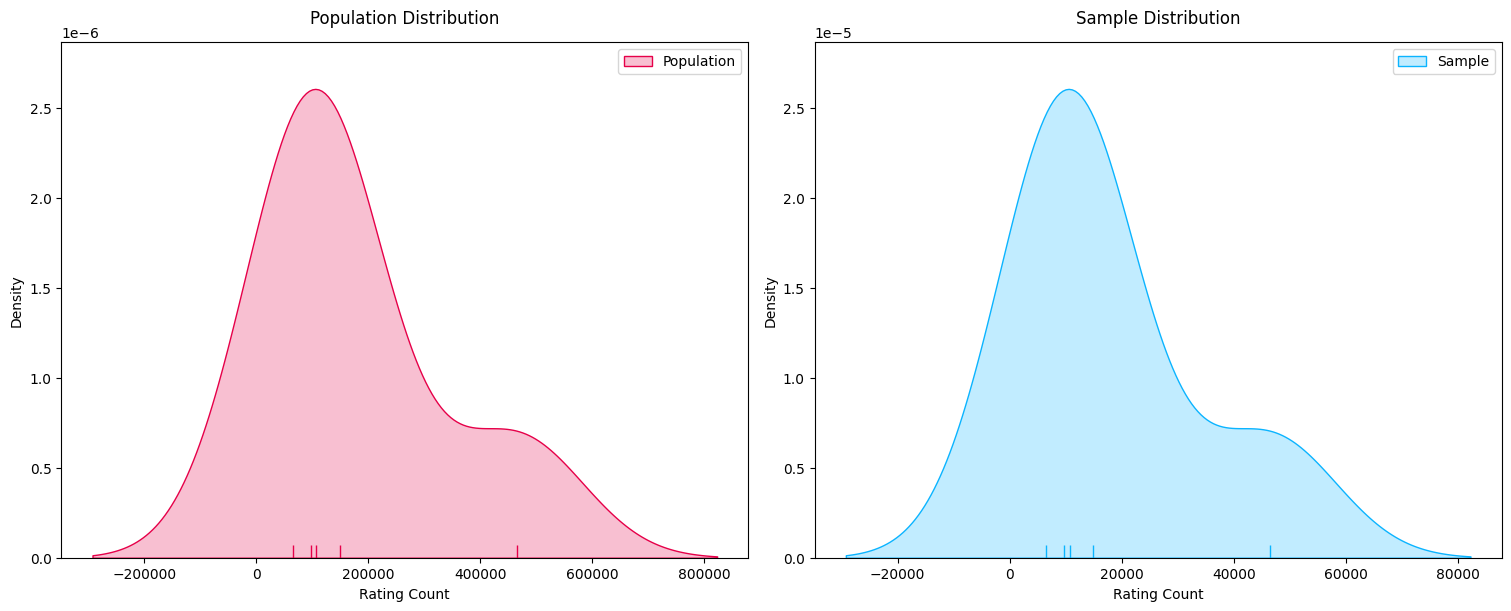

In [10]:
figure, axis = plt.subplots(ncols=2, figsize=(15, 6), constrained_layout=True)


sns.distplot(population_ratings["count"], color="#E60049", label="Population", hist=False, kde_kws={"shade": True}, axlabel="Rating Count", rug=True, ax=axis[0])
axis[0].set_title("Population Distribution", y=1.02)
axis[0].legend(loc="upper right")


sns.distplot(sample_ratings["count"], color="#0BB4FF", label="Sample", hist=False, kde_kws={"shade": True}, axlabel="Rating Count", rug=True, ax=axis[1])
axis[1].set_title("Sample Distribution", y=1.02)
axis[1].legend(loc="upper right")

plt.show()

In [11]:
data.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
style              object
image              object
dtype: object

### Data Cleaning
Missing values in 'reviewerName', 'reviewText', 'summary', 'vote', and 'image' columns are filled with "None." The 'unixReviewTime' column is converted to a human-readable format and renamed as 'reviewTime.'

In [12]:

data['reviewerName'] = data['reviewerName'].fillna("None")
data['reviewText'] = data['reviewText'].fillna("None")
data['summary'] = data['summary'].fillna("None")
data['vote'] = data['vote'].fillna("None")
data['image'] = data['image'].fillna("None")

data['unixReviewTime'] = pd.to_datetime(data['unixReviewTime'], unit='s')
data['reviewTime'] = data['unixReviewTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

data = data.drop(columns=['unixReviewTime'])

data


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,style,image
0,5.0,True,2014-10-20 00:00:00,A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,None,NaN,None
1,2.0,True,2014-09-28 00:00:00,A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",3,NaN,None
2,4.0,False,2014-08-25 00:00:00,A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,None,NaN,None
3,2.0,True,2014-08-24 00:00:00,A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,None,NaN,None
4,3.0,False,2014-07-27 00:00:00,A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
883631,5.0,True,2017-02-21 00:00:00,A1ZSB2Q144UTEY,B01HJHTH5U,Amazon Customer,I absolutely love this dress!! It's sexy and ...,I absolutely love this dress,None,NaN,None
883632,5.0,True,2016-11-25 00:00:00,A2CCDV0J5VB6F2,B01HJHTH5U,Amazon Customer,I'm 5'6 175lbs. I'm on the tall side. I wear a...,I wear a large and ordered a large and it stil...,2,NaN,None
883633,3.0,True,2016-11-10 00:00:00,A3O90PACS7B61K,B01HJHTH5U,Fabfifty,Too big in the chest area!,Three Stars,None,NaN,None
883634,3.0,True,2016-11-10 00:00:00,A2HO94I89U3LNH,B01HJHF97K,Mgomez,"Too clear in the back, needs lining",Three Stars,None,NaN,None


### Handling Missing Values
All missing values in the DataFrame have been dropped, ensuring no null values remain.

In [13]:
data=data.dropna()    
data.isnull().sum()

overall         0
verified        0
reviewTime      0
reviewerID      0
asin            0
reviewerName    0
reviewText      0
summary         0
vote            0
style           0
image           0
dtype: int64

### Distribution of Product Ratings
A bar plot visualizes the distribution of product ratings, highlighting the frequency of each rating. Summary statistics provide insights into the overall dataset characteristics.

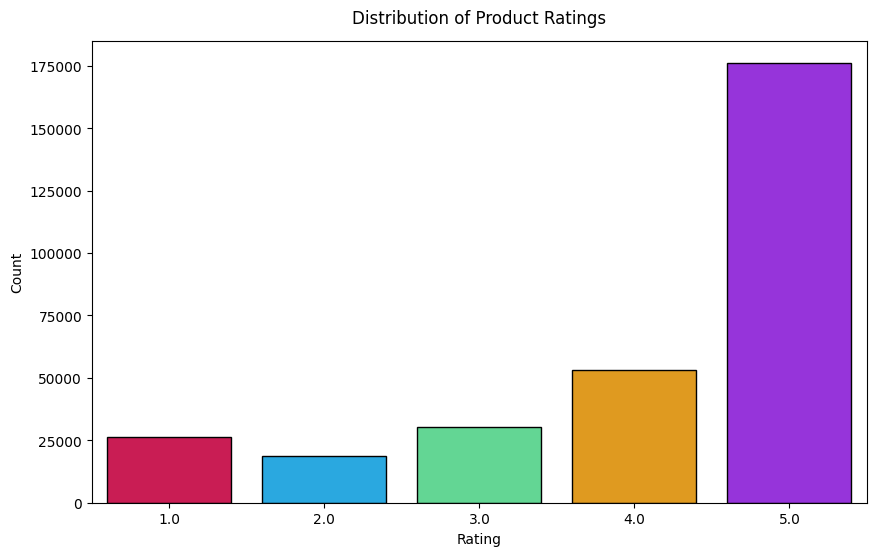

             overall
count  304569.000000
mean        4.099078
std         1.298370
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000


In [14]:
summary_stats = data.describe()


rating_counts = data['overall'].value_counts().reset_index()
rating_counts.columns = ['Rating', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(x="Rating", y="Count", data=rating_counts, palette=["#E60049", "#0BB4FF", "#50E991", "#FFA300", "#9B19F5"], edgecolor="black")
plt.title("Distribution of Product Ratings", y=1.02)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

print(summary_stats)

### Five-Star Reviews Analysis
This analysis calculates the lengths of reviews rated 5.0, providing the maximum, minimum, and average lengths. Understanding review length helps gauge customer satisfaction and engagement levels.

In [15]:
five_star_reviews = data[data["overall"] == 5.0]


In [16]:
max_length = five_star_reviews["reviewText"].str.len().max()
min_length = five_star_reviews["reviewText"].str.len().min()
avg_length = five_star_reviews["reviewText"].str.len().mean()

print("Maximum Length of 5.0 Rated Reviews:", max_length)
print("Minimum Length of 5.0 Rated Reviews:", min_length)
print("Average Length of 5.0 Rated Reviews:", avg_length)


Maximum Length of 5.0 Rated Reviews: 6688
Minimum Length of 5.0 Rated Reviews: 1
Average Length of 5.0 Rated Reviews: 133.53357957027683


### Distribution of Review Lengths for Five-Star Reviews
This visualization displays the distribution of review lengths for reviews rated 5.0, highlighting the density of various review lengths. The plot helps identify trends in customer feedback and engagement based on review length.

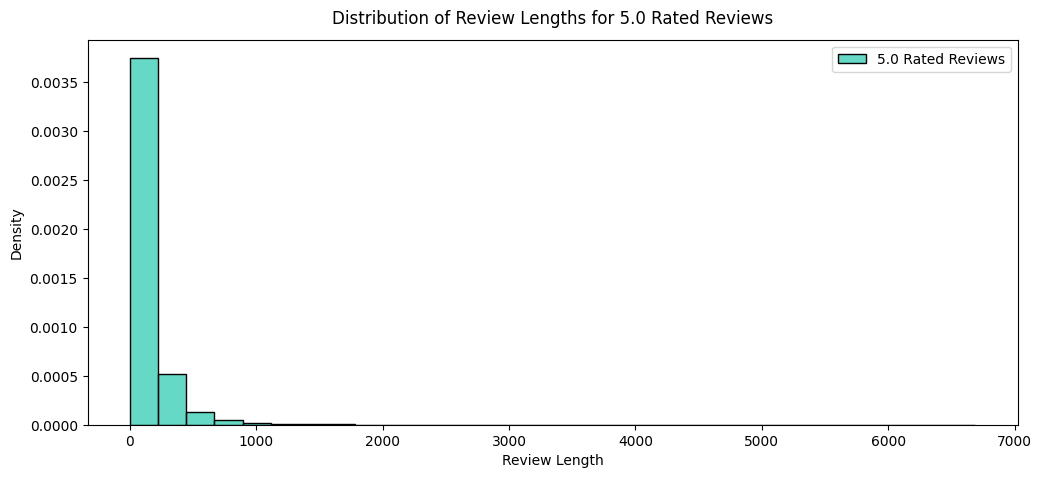

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

sns.histplot(
    five_star_reviews["reviewText"].str.len(), 
    color="#00BFA0", 
    stat="density", 
    bins=30, 
    label="5.0 Rated Reviews", 
    alpha=0.6
)

plt.title("Distribution of Review Lengths for 5.0 Rated Reviews", y=1.02)
plt.xlabel("Review Length")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.show()


### Distribution of Review Lengths for Five-Star Reviews Under 1000 Words
This analysis focuses on five-star reviews with lengths less than 1000 words, providing insights into the range and average lengths of shorter reviews. The histogram visualizes the density of these review lengths, indicating customer engagement in concise feedback.

Maximum Length of 5.0 Rated Reviews Less Than 1000 Words: 999
Minimum Length of 5.0 Rated Reviews Less Than 1000 Words: 1
Average Length of 5.0 Rated Reviews Less Than 1000 Words: 123.57969920943872


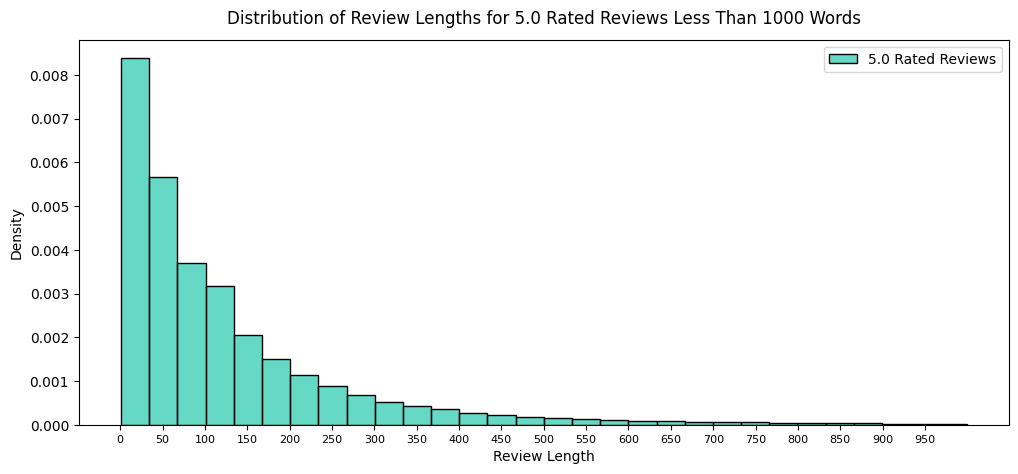

In [18]:
five_star_reviews_subset = five_star_reviews[five_star_reviews["reviewText"].str.len() < 1000]

print("Maximum Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().max())
print("Minimum Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().min())
print("Average Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().mean())

plt.figure(figsize=(12, 5))
sns.histplot(five_star_reviews_subset["reviewText"].str.len(), color="#00BFA0", bins=30, stat="density", alpha=0.6)
plt.title("Distribution of Review Lengths for 5.0 Rated Reviews Less Than 1000 Words", y=1.02)
plt.xlabel("Review Length")
plt.ylabel("Density")
plt.xticks(np.arange(0, 1000, 50), fontsize=8)
plt.legend(["5.0 Rated Reviews"])
plt.show()


### Combined KDE Plot of Review Lengths for All Ratings Under 1000 Words
This visualization illustrates the density of review lengths across different ratings, focusing on reviews that are less than 1000 words. The KDE plot allows for a comparative analysis of how the length of reviews varies with rating, highlighting trends in customer feedback.

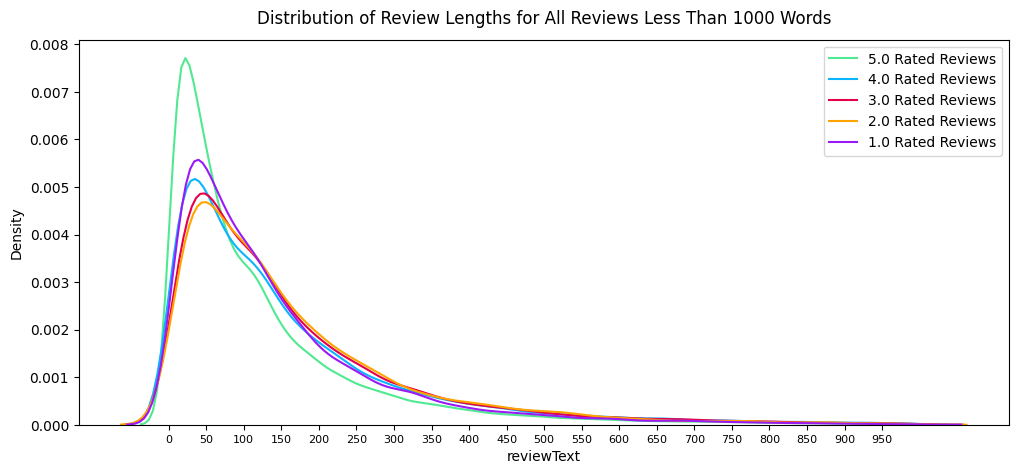

In [19]:

four_star_reviews = data[data["overall"] == 4.0]
three_star_reviews = data[data["overall"] == 3.0]
two_star_reviews = data[data["overall"] == 2.0]
one_star_reviews = data[data["overall"] == 1.0]

four_star_reviews_subset = four_star_reviews[four_star_reviews["reviewText"].str.len() < 1000]
three_star_reviews_subset = three_star_reviews[three_star_reviews["reviewText"].str.len() < 1000]
two_star_reviews_subset = two_star_reviews[two_star_reviews["reviewText"].str.len() < 1000]
one_star_reviews_subset = one_star_reviews[one_star_reviews["reviewText"].str.len() < 1000]

plt.figure(figsize=(12, 5))
sns.kdeplot(five_star_reviews_subset["reviewText"].str.len(), color="#50E991", label="5.0 Rated Reviews", fill=False)
sns.kdeplot(four_star_reviews_subset["reviewText"].str.len(), color="#0BB4FF", label="4.0 Rated Reviews", fill=False)
sns.kdeplot(three_star_reviews_subset["reviewText"].str.len(), color="#E60049", label="3.0 Rated Reviews", fill=False)
sns.kdeplot(two_star_reviews_subset["reviewText"].str.len(), color="#FFA300", label="2.0 Rated Reviews", fill=False)
sns.kdeplot(one_star_reviews_subset["reviewText"].str.len(), color="#9B19F5", label="1.0 Rated Reviews", fill=False)

plt.title("Distribution of Review Lengths for All Reviews Less Than 1000 Words", y=1.02)
plt.xticks(np.arange(0, 1000, 50), fontsize=8)
plt.legend(loc="upper right")
plt.show()


### Five-Star Reviews Length Statistics
This code filters five-star reviews to include only those with less than 1000 words and calculates their length statistics. It displays the maximum, minimum, and average lengths of these filtered reviews, providing insight into the characteristics of highly rated feedback.

In [20]:
five_star_reviews_subset = five_star_reviews[five_star_reviews["reviewText"].str.len() < 1000]
print("Maximum Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().max())
print("Minimum Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().min())
print("Average Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().mean())


Maximum Length of 5.0 Rated Reviews Less Than 1000 Words: 999
Minimum Length of 5.0 Rated Reviews Less Than 1000 Words: 1
Average Length of 5.0 Rated Reviews Less Than 1000 Words: 123.57969920943872


### Change in 5.0 Rated Reviews Over Time
This code visualizes the trend of five-star rated reviews over time using a line chart. It illustrates how the quantity of these reviews has varied by date, providing insights into customer satisfaction trends for the products analyzed.

In [21]:
majority_review_time = five_star_reviews["reviewTime"].value_counts()
majority_review_time = majority_review_time.sort_index()

figure = go.Figure()
figure.add_trace(go.Scatter(
    x=majority_review_time.index,
    y=majority_review_time.values,
    mode="lines",
    name="lines",
    line=dict(color="#00BFA0", width=2),
    fill="tozeroy",
    fillcolor="rgba(0, 191, 160, 0.2)"
))

figure.update_layout(
    title="Change in 5.0 Rated Reviews Over Time",
    xaxis_title="Date",
    yaxis_title="Number of Reviews"
)
figure.show()


### Change in 5.0 Rated Reviews Over Time
This code generates a line chart showing the number of five-star rated reviews over time. It helps to visualize trends in customer satisfaction, indicating periods of higher or lower review activity.

In [22]:
majority_review_time = five_star_reviews["reviewTime"].value_counts()
majority_review_time = majority_review_time.sort_index()

figure = go.Figure()
figure.add_trace(go.Scatter(
    x=majority_review_time.index,
    y=majority_review_time.values,
    mode="lines",
    name="lines",
    line=dict(color="#00BFA0", width=2),
    fill="tozeroy",
    fillcolor="rgba(0, 191, 160, 0.2)"
))

figure.update_layout(
    title="Change in 5.0 Rated Reviews Over Time",
    xaxis_title="Date",
    yaxis_title="Number of Reviews"
)
figure.show()


### Percentage of Verified 5.0 Rated Reviews
This code creates a pie chart that illustrates the proportion of verified versus unverified five-star reviews. It provides insights into customer trust and the authenticity of positive feedback.

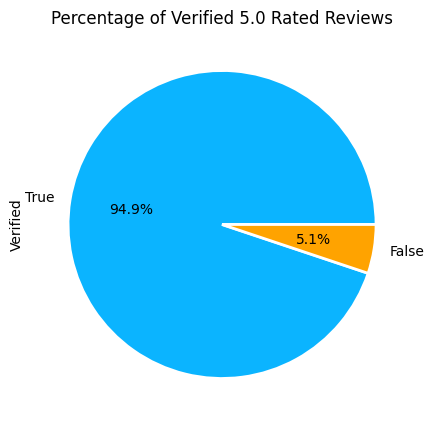

In [23]:
verification_status = five_star_reviews["verified"].value_counts()


verification_status.plot.pie(
    autopct="%1.1f%%",
    figsize=(5, 5),
    colors=["#0BB4FF", "#FFA300"],
    title="Percentage of Verified 5.0 Rated Reviews",
    fontsize=10,
    wedgeprops={"linewidth": 2, "edgecolor": "white"}
)
plt.ylabel("Verified")
plt.show()


### Correlation Between Review Length and Rating
This code calculates the correlation between the length of reviews and their ratings, adding a new column for review lengths. A scatter plot with a regression line visually represents this relationship, and the p-value indicates the statistical significance of the correlation.

Correlation Between Review Length and Rating: -0.0567476023048452


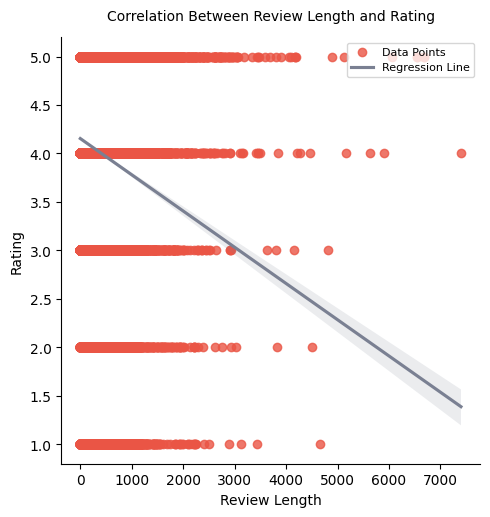

P-Value: 1.2170255765900145e-215


In [24]:
data["Review_Length"] = data["reviewText"].str.len()  
print("Correlation Between Review Length and Rating:", data["Review_Length"].corr(data["overall"])) 

sns.lmplot(x="Review_Length", y="overall", data=data, height=5, scatter_kws={"color": "#EA5545"}, line_kws={"color": "#7A8092"})
plt.title("Correlation Between Review Length and Rating", y=1.02, fontsize=10)
plt.xlabel("Review Length")
plt.ylabel("Rating")
plt.legend(["Data Points", "Regression Line"], loc="upper right", fontsize=8)
plt.show()


print("P-Value:", stats.pearsonr(data["Review_Length"], data["overall"])[1])  


### Correlation Calculation and Visualization
This code computes the correlation between review lengths and ratings, displaying the result. A scatter plot with a regression line illustrates this relationship, helping to visually assess how review length may influence the rating given.

In [25]:
data["Review_Length"] = data["reviewText"].str.len()  

Correlation Between Review Length and Rating: -0.0567476023048452


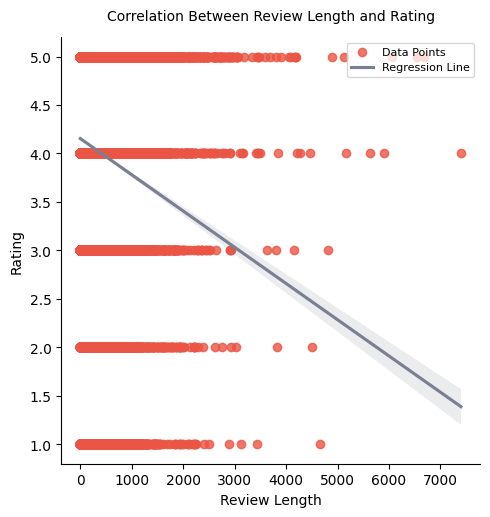

In [26]:
correlation = data["Review_Length"].corr(data["overall"])  
print("Correlation Between Review Length and Rating:", correlation)

sns.lmplot(x="Review_Length", y="overall", data=data, height=5, scatter_kws={"color": "#EA5545"}, line_kws={"color": "#7A8092"})
plt.title("Correlation Between Review Length and Rating", y=1.02, fontsize=10)
plt.xlabel("Review Length")
plt.ylabel("Rating")
plt.legend(["Data Points", "Regression Line"], loc="upper right", fontsize=8)
plt.show()


### Reviewer Count and Rating Correlation
This code calculates the correlation between the number of reviews per reviewer and their ratings, displaying the result. A scatter plot with a regression line visually represents the relationship, helping to analyze if more reviews correlate with higher ratings.

In [27]:
reviewer_counts = data["reviewerID"].value_counts()  
reviewer_counts = reviewer_counts.to_frame().reset_index()  
reviewer_counts.columns = ["reviewerID", "Review_Count"]  
reviewer_counts = reviewer_counts.merge(data[["reviewerID", "overall"]], on="reviewerID", how="left")  
reviewer_counts = reviewer_counts.drop_duplicates(subset=["reviewerID"])  
reviewer_counts = reviewer_counts.sort_values(by="overall", ascending=False)  
reviewer_counts = reviewer_counts.reset_index(drop=True)  


Correlation Between Number of Reviews and Rating: 0.008498792797146904


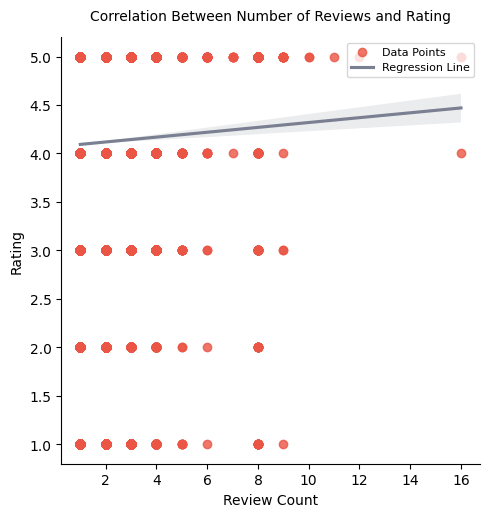

In [28]:
correlation = reviewer_counts["Review_Count"].corr(reviewer_counts["overall"])  # Calculating correlation
print("Correlation Between Number of Reviews and Rating:", correlation)

sns.lmplot(x="Review_Count", y="overall", data=reviewer_counts, height=5, scatter_kws={"color": "#EA5545"}, line_kws={"color": "#7A8092"})
plt.title("Correlation Between Number of Reviews and Rating", y=1.02, fontsize=10)
plt.xlabel("Review Count")
plt.ylabel("Rating")
plt.legend(["Data Points", "Regression Line"], loc="upper right", fontsize=8)
plt.show()


### Hypothesis Test for Correlation Significance
This code computes the p-value for the correlation between the number of reviews and ratings, helping to determine the significance of the correlation. A low p-value suggests that the correlation observed is statistically significant.

In [29]:

p_value = stats.pearsonr(reviewer_counts["Review_Count"], reviewer_counts["overall"])[1]  # Calculating p-value
print("P-Value:", p_value)


P-Value: 7.858487041690147e-06


### Function to Extract All Words from Reviews
This code defines a function `get_all_words`, which extracts all words from a specified column in a DataFrame containing reviews. The function splits each review into words and aggregates them into a list. It is then applied to the review texts for each star rating (1 to 5), resulting in separate lists for each rating's reviews.

In [30]:

def get_all_words(dataframe, column):
    all_words = []

    def add_words(review):
        words = review.split(" ")  
        all_words.extend(words) 

    dataframe[column].apply(add_words) 
    return all_words


In [31]:

all_words_five_star_reviews = get_all_words(five_star_reviews, "reviewText")
all_words_four_star_reviews = get_all_words(four_star_reviews, "reviewText")
all_words_three_star_reviews = get_all_words(three_star_reviews, "reviewText")
all_words_two_star_reviews = get_all_words(two_star_reviews, "reviewText")
all_words_one_star_reviews = get_all_words(one_star_reviews, "reviewText")


### Word Count Function and Usage
The function get_word_counts computes the frequency of each word in the provided list of words, removes common English stopwords, and returns a DataFrame containing the counts.

In [32]:

def get_word_counts(all_words):
    word_counts = pd.Series(all_words).value_counts()  
    word_counts = word_counts.to_frame().reset_index() 
    word_counts.columns = ["Word", "Count"]  
    word_counts = word_counts[~word_counts["Word"].isin(stopwords.words("english"))]
    return word_counts




### Result for Five-Star Reviews
To display the word counts for the five-star reviews, simply run `word_counts_five_stars` as shown. This will give you a DataFrame with words and their respective counts after filtering out the stopwords.


In [33]:

word_counts_five_stars = get_word_counts(all_words_five_star_reviews)
word_counts_four_stars = get_word_counts(all_words_four_star_reviews)
word_counts_three_stars = get_word_counts(all_words_three_star_reviews)
word_counts_two_stars = get_word_counts(all_words_two_star_reviews)
word_counts_one_star = get_word_counts(all_words_one_star_reviews)

word_counts_five_stars


,Word,Count
0,I,154518
6,,72628
23,The,25494
24,love,24744
25,fit,21836
...,...,...
120303,fantastic.\nmy,1
120304,"harder.\n\nAlso,",1
120305,Venitian.,1
120306,dowsing,1


The code generates word clouds for reviews ranging from five stars to one star. Each cloud visually represents the most frequent words in reviews for each rating, with larger words indicating higher frequency. The clouds are displayed in a 2x3 grid without axes for clarity.

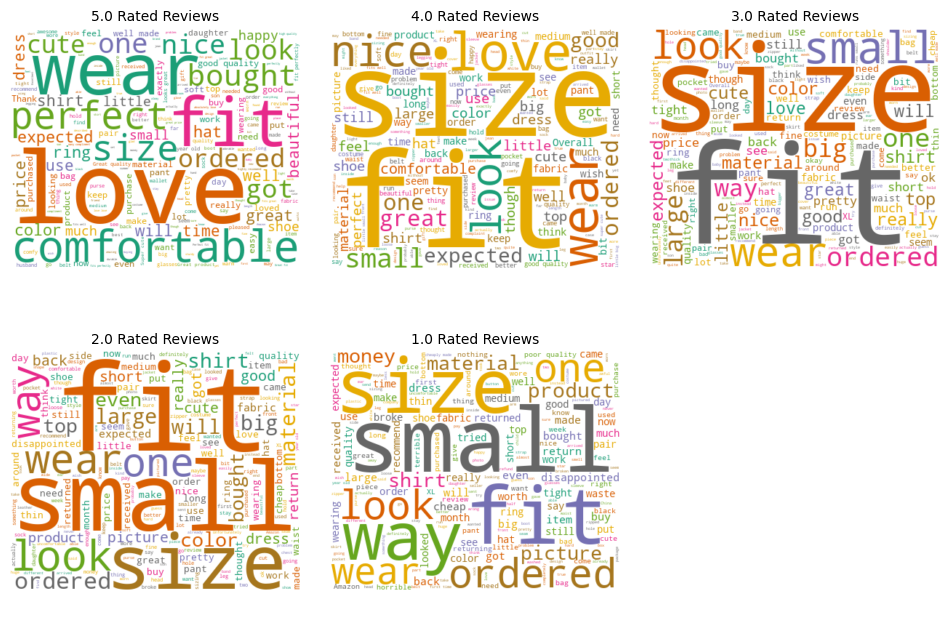

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


figure, axis = plt.subplots(2, 3, figsize=(12, 8))
figure.subplots_adjust(hspace=0.1, wspace=0.1)


wordcloud_five_stars = WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_five_star_reviews))
wordcloud_four_stars = WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_four_star_reviews))
wordcloud_three_stars = WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_three_star_reviews))
wordcloud_two_stars = WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_two_star_reviews))
wordcloud_one_star = WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_one_star_reviews))


axis[0, 0].imshow(wordcloud_five_stars, interpolation="bilinear")
axis[0, 0].set_title("5.0 Rated Reviews", fontsize=10)
axis[0, 0].axis("off")

axis[0, 1].imshow(wordcloud_four_stars, interpolation="bilinear")
axis[0, 1].set_title("4.0 Rated Reviews", fontsize=10)
axis[0, 1].axis("off")

axis[0, 2].imshow(wordcloud_three_stars, interpolation="bilinear")
axis[0, 2].set_title("3.0 Rated Reviews", fontsize=10)
axis[0, 2].axis("off")

axis[1, 0].imshow(wordcloud_two_stars, interpolation="bilinear")
axis[1, 0].set_title("2.0 Rated Reviews", fontsize=10)
axis[1, 0].axis("off")

axis[1, 1].imshow(wordcloud_one_star, interpolation="bilinear")
axis[1, 1].set_title("1.0 Rated Reviews", fontsize=10)
axis[1, 1].axis("off")

axis[1, 2].axis("off")  

plt.show()
